In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import ConcatDataset, DataLoader
import torch.nn.functional as F

import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('../')

import random
seed = 777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

import os
os.environ["PYTHONHASHSEED"]=str(seed)
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

import loader.load_from_h5 as loadh5
from model.model_binary import MyModel

In [2]:
normal_data_file = glob.glob('../data/normal_dataset.h5')
Anomaly_data_file = glob.glob('../data/Anomaly_dataset.h5')

norm_ds = loadh5.FeatureDataset(normal_data_file).get_dataset(label=0,split_type='training')
ano_ds = loadh5.FeatureDataset(Anomaly_data_file).get_dataset(label=1,split_type='training')
train_set = ConcatDataset([norm_ds,ano_ds])
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)

norm_ds = loadh5.FeatureDataset(normal_data_file).get_dataset(label=0,split_type='validation')
ano_ds = loadh5.FeatureDataset(Anomaly_data_file).get_dataset(label=1,split_type='validation')
val_set = ConcatDataset([norm_ds,ano_ds])
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)

norm_ds = loadh5.FeatureDataset(normal_data_file).get_dataset(split_type='test')
ano_ds = loadh5.FeatureDataset(Anomaly_data_file).get_dataset(split_type='test')
test_set = ConcatDataset([norm_ds,ano_ds])
test_loader = DataLoader(test_set,batch_size=64,shuffle=False)

#train_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='training')
#val_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='validation')
#test_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='test')

model = MyModel().to('cuda')

c_criterion = nn.NLLLoss()
t_criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

target_la = 0

epochs = 50

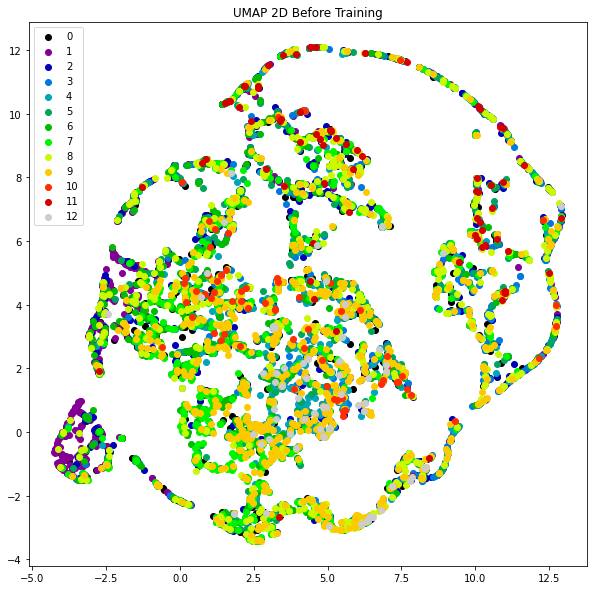

In [3]:
model.eval()
tst_embedded = []
tst_y = []
for x, y in test_loader:
    x = Variable(x.float()).to('cuda')
    embedded = model.embedding(x.view(-1,784)).detach().cpu()
    tst_embedded.append(embedded)
    tst_y.append(y)
tst_embedded = torch.cat(tst_embedded)
tst_y = torch.cat(tst_y)
#print(tst_embedded.shape,tst_y.shape)
hle = umap.UMAP(random_state=0,metric='euclidean',n_components=2,n_neighbors=20,min_dist=0).fit_transform(tst_embedded)
c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(tst_y)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(tst_y))):
    #print('Class ',i,'x :',hle[tst_y==i,0])
    #print('Class ',i,'y :',hle[tst_y==i,1])
    plt.scatter(hle[tst_y==i,0],hle[tst_y==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')
plt.title('UMAP 2D Before Training')
plt.savefig('../result/model_ownAnomaly_beforeTraining.png')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


Validation Accuracy 99.88210818307905 at Epoch 1


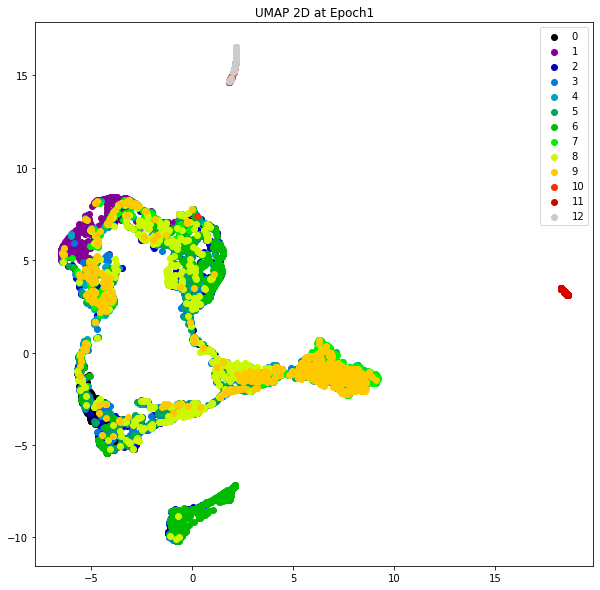

  8%|▊         | 4/50 [1:12:33<13:51:41, 1084.82s/it]

Validation Accuracy 99.9375866851595 at Epoch 5


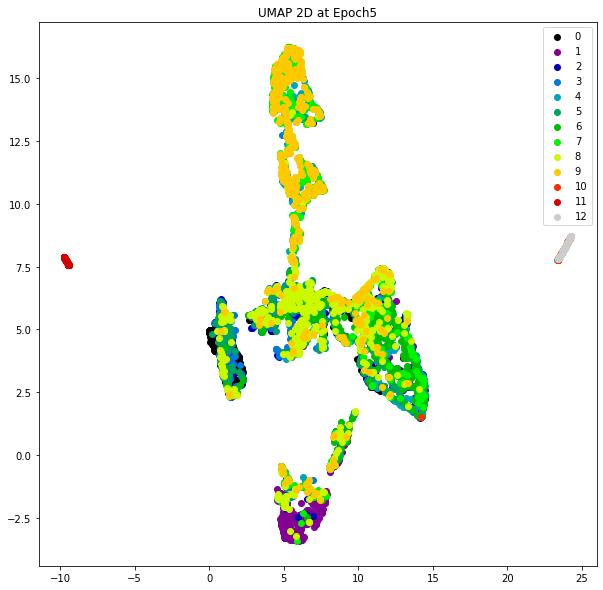

 18%|█▊        | 9/50 [2:42:41<12:18:17, 1080.44s/it]

Validation Accuracy 99.97919556171983 at Epoch 10


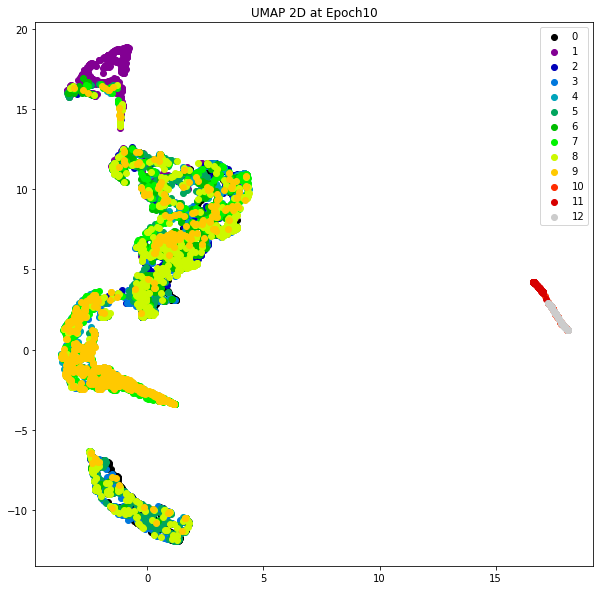

 28%|██▊       | 14/50 [4:13:09<10:50:12, 1083.68s/it]

Validation Accuracy 99.97226074895977 at Epoch 15


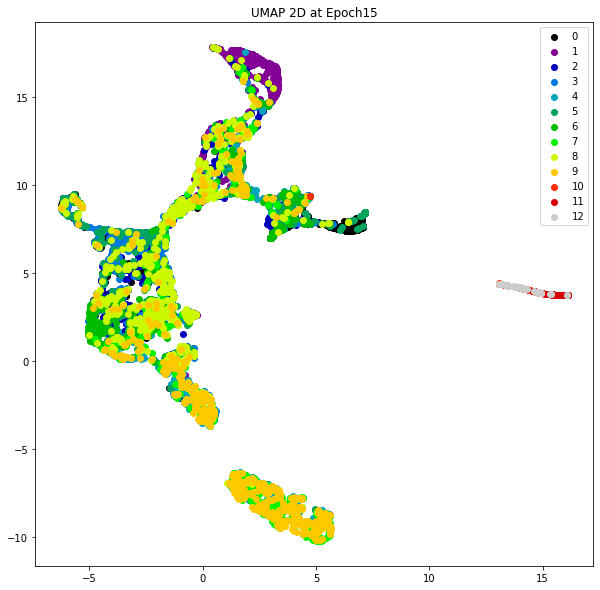

 38%|███▊      | 19/50 [5:43:42<9:19:58, 1083.82s/it] 

Validation Accuracy 99.97919556171983 at Epoch 20


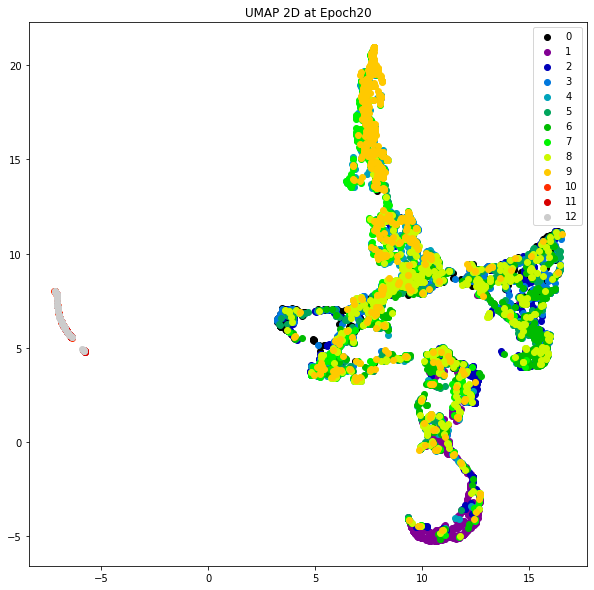

 48%|████▊     | 24/50 [7:14:16<7:50:25, 1085.60s/it]

Validation Accuracy 99.97919556171983 at Epoch 25


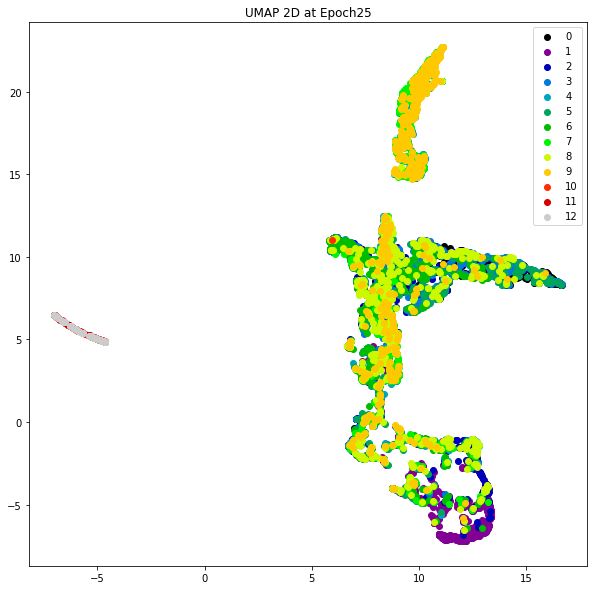

 58%|█████▊    | 29/50 [8:44:45<6:19:29, 1084.28s/it]

Validation Accuracy 99.97226074895977 at Epoch 30


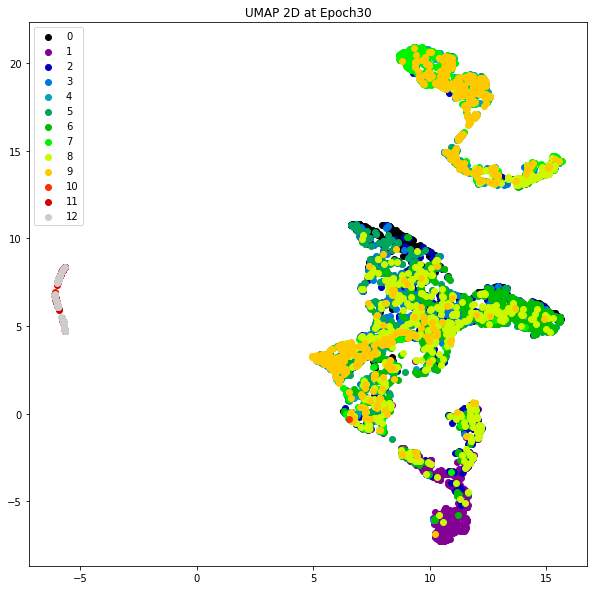

 68%|██████▊   | 34/50 [10:15:09<4:49:01, 1083.87s/it]

Validation Accuracy 99.97226074895977 at Epoch 35


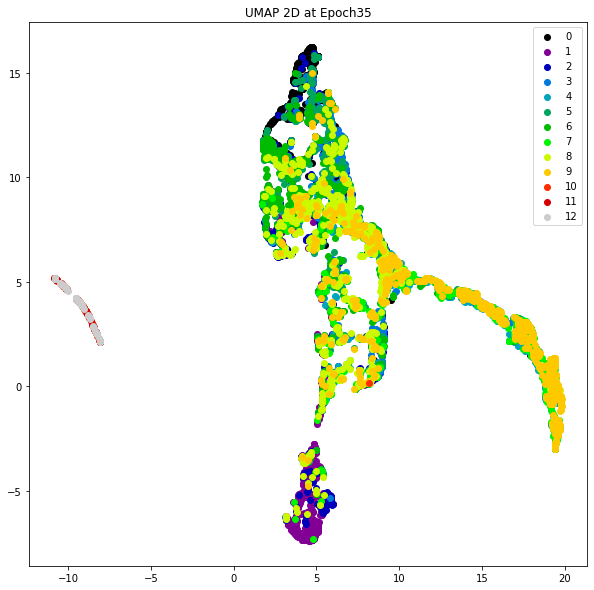

 78%|███████▊  | 39/50 [11:45:40<3:18:52, 1084.81s/it]

Validation Accuracy 99.97919556171983 at Epoch 40


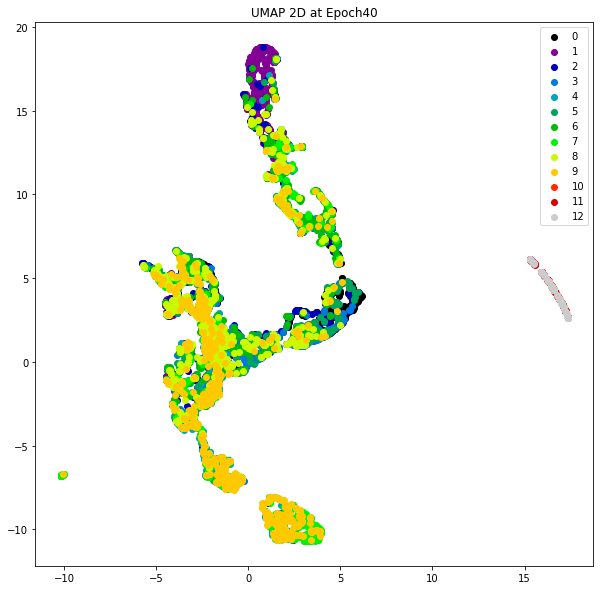

 88%|████████▊ | 44/50 [13:16:06<1:48:27, 1084.64s/it]

Validation Accuracy 99.97226074895977 at Epoch 45


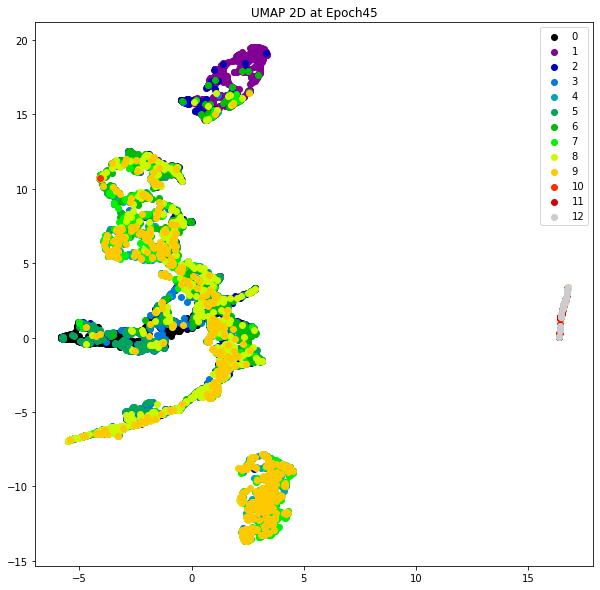

 98%|█████████▊| 49/50 [14:46:37<18:05, 1085.22s/it]  

Validation Accuracy 99.97919556171983 at Epoch 50


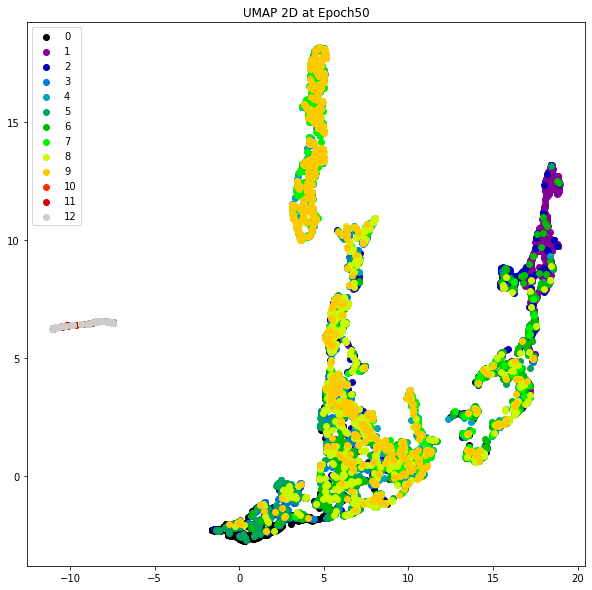

100%|██████████| 50/50 [15:04:54<00:00, 1085.90s/it]


In [4]:
train_loss=[]
val_loss = []
best_acc = 0
for epoch in tqdm(range(1,epochs+1)):
#for epoch in range(1,epochs+1):
    model.train()
    b_loss=[]
    for x ,y in train_loader:
        #print(y)
        for y_idx, y_i in enumerate(y):
            if y_i == target_la:
                y[y_idx] = 0
            else:
                y[y_idx] = 1
        #print(y)
        
        x = Variable(x.float()).to('cuda')
        y = Variable(y.type(torch.LongTensor)).to('cuda')
        
        out = model(x)
        embedded = model.embedding(x.view(-1,784))

        triplet_tensor = []
        triplet_label = []
        
        anchor_x, anchor_y = embedded[y==0], y[y==0]
        positive_x, positive_y = embedded[y==0], y[y==0]
        negative_x, negative_y = embedded[y!=0], y[y!=0]
        #print(anchor.shape,positive.shape,negative.shape)
        a_ind = torch.arange(0,len(anchor_x))
        p_ind = torch.arange(0,len(positive_x))
        n_ind = torch.arange(0,len(negative_x))
        triplet_ind = torch.cartesian_prod(a_ind,p_ind,n_ind)
        #print(triplet_ind.shape)
        
        for a,p,n in triplet_ind:
            if a != p:
                #print(anchor_x[a].shape,positive_x[p].shape,negative_x[n].shape)
                triplet_tensor.append(torch.stack([anchor_x[a],positive_x[p],negative_x[n]]))
                triplet_label.append(torch.stack([anchor_y[a],positive_y[p],negative_y[n]]))
                #break
        
        if len(triplet_tensor)==0:
            continue
        else:
            triplet_tensor = torch.stack(triplet_tensor)
            triplet_label = torch.stack(triplet_label)
            #print(triplet_tensor.shape)
            
            anchor = triplet_tensor[:,0]
            positive = triplet_tensor[:,1]
            negative = triplet_tensor[:,2]
            
            optimizer.zero_grad()
            #print(out.shape,y.shape)
            classification_loss = c_criterion(out,y)
            triplet_loss = t_criterion(anchor,positive,negative)
            loss = classification_loss + triplet_loss
            b_loss.append(loss.cpu().item())
            loss.backward()
            optimizer.step()
    train_loss.append(np.array(b_loss).mean())
    
    model.eval()
    b_loss=[]
    with torch.no_grad():
        total = 0
        correct = 0
        for x,y in val_loader:
            for y_idx, y_i in enumerate(y):
                if y_i == target_la:
                    y[y_idx] = 0
                else:
                    y[y_idx] = 1
            
            x = Variable(x.float()).to('cuda')
            y = Variable(y.type(torch.LongTensor)).to('cuda')
            
            out = model(x)
            
            out_sm = F.softmax(out,dim=1).cpu()
            predict = (F.softmax(out_sm,dim=1)).argmax(1).cpu()
            
            total += y.size(0)
            correct += (predict ==y.cpu()).sum().item()
            
            loss = c_criterion(out,y)
            b_loss.append(loss.cpu().item())
    val_loss.append(np.array(b_loss).mean())
    acc = 100 * (correct / total)
    if best_acc < acc:
        best_acc = acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        torch.save(best_state_dict,'../result/model_ownAnomaly_best.pth')
    
    if epoch % 5 == 0 or epoch == 1:
        print("Validation Accuracy",acc,'at Epoch',epoch)
        torch.save(best_state_dict,f'../result/model_ownAnomaly_{epoch}epoch.pth')
        model.eval()
        with torch.no_grad():
            tst_embedded = []
            tst_y = []
            for x, y in test_loader:
                x = Variable(x.float()).to('cuda')
                embedded = model.embedding(x.view(-1,784)).detach().cpu()
                tst_embedded.append(embedded)
                tst_y.append(y)
            tst_embedded = torch.cat(tst_embedded)
            tst_y = torch.cat(tst_y)
            #print(tst_embedded.shape,tst_y.shape)
            hle = umap.UMAP(random_state=0,metric='euclidean',n_components=2,n_neighbors=20,min_dist=0).fit_transform(tst_embedded)
            c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(tst_y)))]
            plt.figure(figsize=(10,10))
            for i in range(0,len(np.unique(tst_y))):
                #print('Class ',i,'x :',hle[tst_y==i,0])
                #print('Class ',i,'y :',hle[tst_y==i,1])
                plt.scatter(hle[tst_y==i,0],hle[tst_y==i,1],label=i,color=c_lst[i])
            plt.legend(loc='best')
            plt.title('UMAP 2D at Epoch'+str(epoch))
            plt.savefig(f'../result/model_ownAnomaly_{epoch}epoch.png')
            plt.show()
            plt.close()


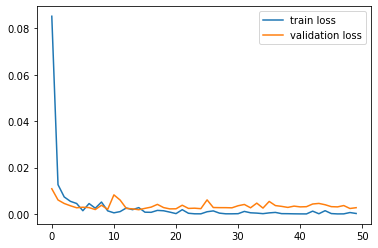

In [5]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend()
plt.show()

In [6]:
print("Best Validation Accuracy Epoch",best_epoch)
print("Best Validation Accuracy(%)",best_acc)
model.load_state_dict(torch.load('../result/model_ownAnomaly_best.pth'))

Best Validation Accuracy Epoch 8
Best Validation Accuracy(%) 99.97919556171983


<All keys matched successfully>

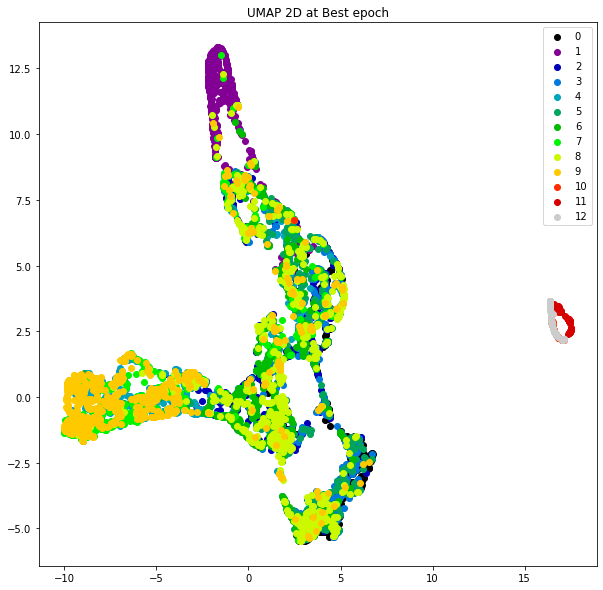

In [7]:
model.eval()
tst_embedded = []
tst_y = []
with torch.no_grad():
    for x, y in test_loader:
        x = Variable(x.float()).to('cuda')
        embedded = model.embedding(x.view(-1,784)).detach().cpu()
        tst_embedded.append(embedded)
        tst_y.append(y)
            
tst_embedded = torch.cat(tst_embedded)
tst_y = torch.cat(tst_y)
#print(tst_embedded.shape,tst_y.shape)
hle = umap.UMAP(random_state=0,metric='euclidean',n_components=2,n_neighbors=20,min_dist=0).fit_transform(tst_embedded)
c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(tst_y)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(tst_y))):
    #print('Class ',i,'x :',hle[tst_y==i,0])
    #print('Class ',i,'y :',hle[tst_y==i,1])
    plt.scatter(hle[tst_y==i,0],hle[tst_y==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')
plt.title('UMAP 2D at Best epoch')
plt.savefig('../result/model_ownAnomaly_best.png')
plt.show()

In [8]:
label = []
pred = []
with torch.no_grad():
    for x, y in test_loader:
        #print(y)
        for y_idx, y_i in enumerate(y):
            #print(y.shape)
            if y_i == target_la:
                y[y_idx] = 0
            else:
                y[y_idx] = 1
        #print(y)
        x = Variable(x.float()).to('cuda')
        y = Variable(y.type(torch.LongTensor)).to('cuda')
        out = model(x)
                
        out_sm = F.softmax(out,dim=1).cpu()
        predict = (F.softmax(out_sm,dim=1)).argmax(1).cpu()
        label.append(y.cpu().numpy())
        pred.append(predict.cpu().numpy())
label = np.concatenate(label)
pred = np.concatenate(pred)
print(label.shape)
print(pred.shape)
confusion_mat = confusion_matrix(label,pred)
print(confusion_mat)

(7210,)
(7210,)
[[ 708    0]
 [6291  211]]
